In [11]:
import pandas as pd 
import numpy as np 

from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

# 데이터 로드

In [12]:
file_path = r"C:\Users\82106\Desktop\데이콘 한솔데크\data\train.csv"
train = pd.read_csv(file_path)

In [13]:
file_path = r"C:\Users\82106\Desktop\데이콘 한솔데크\data\test.csv"
test = pd.read_csv(file_path)

In [14]:
file_path = r"C:\Users\82106\Desktop\데이콘 한솔데크\data\sample_submission.csv"
sample = pd.read_csv(file_path)

# 전처리

In [17]:
from konlpy.tag import Komoran
import re
import string

komoran = Komoran()

with open('C:/Users/82106/Desktop/데이콘 한솔데크/불용어.txt', 'r', encoding = 'UTF-8') as f:
  list_file = f.readlines() 
stopwords = list_file[0].split(",")

# 정규화
def preprocess(text):
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', ' ', str(text).strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text


# 명사/영단어 추출, 한글자 제외, 불용어 제거
def remove_stopwords(text):
    n = []
    word = komoran.nouns(text)
    p = komoran.pos(text)
    for pos in p:
      if pos[1] in ['SL']:
        word.append(pos[0])
    for w in word:
      if len(w)>1 and w not in stopwords:
        n.append(w)
    return " ".join(n)

# 최종
def finalpreprocess(text):
  return remove_stopwords(preprocess(text))

# 전처리 및 불용어 제거 적용 (두 단계)
train["재발방지대책 및 향후조치계획"] = train["재발방지대책 및 향후조치계획"].apply(finalpreprocess)

# 결과 확인
print(train["재발방지대책 및 향후조치계획"].head())

0                              고소 작업 추락 위험 부위 안전 장비 설치
1                                  재발 방지 대책 마련 안전교육 실시
2            현장 자재 정리 안전 관리 철저 재발 방지 대책 공문 발송 향후 조치 계획
3    위험성 평가 교육 작업장 위험 요인 안전 수칙 근로자 전파 근로자 안전교육 강화 사...
4    자재 정리 작업 세부 작업 방법 교육 실시 작업 구간 이동 경로 점검 장애물 사전 ...
Name: 재발방지대책 및 향후조치계획, dtype: object


# 모델 로드

In [18]:
from sentence_transformers import SentenceTransformer

# Embedding Vector 추출에 활용할 모델(jhgan/ko-sbert-sts) 불러오기
model = SentenceTransformer('jhgan/ko-sbert-sts', use_auth_token=False)

c:\Users\82106\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
c:\Users\82106\AppData\Local\Programs\Python\Python310\lib\site-packages\sentence_transformers\SentenceTransformer.py:195: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v4 of SentenceTransformers.
  warnings.warn(


# 인적사고에 따른 재발방지대책 임베딩 및 대표 대책 인덱스 추출

In [19]:
grouped = train.groupby("인적사고")

res = {}
cosine_res = []
for name, group in tqdm(grouped):
    plan = group["재발방지대책 및 향후조치계획"]
    vectors = np.stack(plan.apply(model.encode).to_numpy())
    similarity = cosine_similarity(vectors, vectors)    
    cosine_res += similarity[similarity.mean(axis=1).argmax()].tolist()
    res[name] = plan.iloc[similarity.mean(axis=1).argmax()]

  0%|          | 0/23 [00:00<?, ?it/s]

# 각 히스토그램에 따른 임베딩 개수

In [20]:
arr = cosine_res

# 0.1 단위로 구간을 지정
bins = np.arange(0, 1.1, 0.1)  # 0.0 ~ 1.0을 0.1 간격으로 나눔

# 히스토그램 계산
hist, bin_edges = np.histogram(arr, bins=bins)

# 결과 출력
for i in range(len(hist)):
    print(f"Range {bin_edges[i]:.1f} - {bin_edges[i+1]:.1f}: {hist[i]}개")

Range 0.0 - 0.1: 0개
Range 0.1 - 0.2: 6개
Range 0.2 - 0.3: 116개
Range 0.3 - 0.4: 581개
Range 0.4 - 0.5: 1838개
Range 0.5 - 0.6: 4416개
Range 0.6 - 0.7: 8572개
Range 0.7 - 0.8: 6871개
Range 0.8 - 0.9: 958개
Range 0.9 - 1.0: 21개


In [ ]:
res

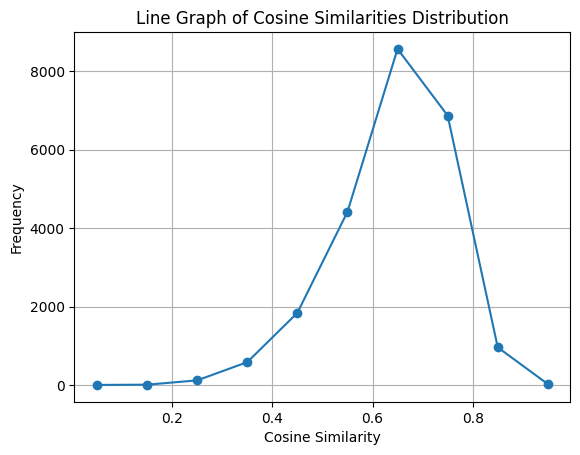

In [25]:
import matplotlib.pyplot as plt

# 코사인 유사도 분포 시각화 (선 그래프)
arr = np.array(cosine_res)
bins = np.arange(0, 1.1, 0.1)
hist, bin_edges = np.histogram(arr, bins=bins)

# bin 간격의 중앙값 계산
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure()
plt.plot(bin_centers, hist, marker='o', linestyle='-')
plt.title("Line Graph of Cosine Similarities Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 대표 대책 임베딩

In [21]:
res_v = {}
for k,v in res.items():
    res_v[k] = model.encode(v)

In [ ]:
sample.info()

# 테스트 데이터에 적용

In [22]:
for i in range(len(test)):
    accident = test.loc[i, "인적사고"]
    sample.loc[i, "재발방지대책 및 향후조치계획"] = res[accident]
    sample.iloc[i, 2:] = res_v[accident]

In [23]:
sample.to_csv("C:/Users/82106/Desktop/데이콘 한솔데크/data/result/baseline.csv", index=False, encoding='utf-8-sig')